In this notebook, I've proposed a method in which the stopping criterion is not a fixed number of iterations.

Suppose that we have $K$ clusters and for each cluster we have a sampling set (the nodes which we know their true clusters), for each cluster $C_k$ we run `algorithm 1` based on its sampling set and then for each node $i \in V$ we decide whether it's in the cluster $C_k$ or it's not. The stopping criterion in this notebook is that every `x=5` number of iterations in `algorithm 1`, we check whether the cluster for the sampling sets (for the cluster $C_k$ and other clusters) are true or not, if the clusters are true (the accuracy is $1.0$) or the accuracy doesn't change over the last `x` iterations, we will stop the algorithm. We can also add a minimum number of iterations for the algorithm (in this notebook the minimum number of iterations is $10$).

In [2]:
import random
import math
import itertools
import numpy as np
from sklearn.cluster import spectral_clustering, SpectralClustering
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

import warnings
warnings.filterwarnings('ignore')

n_samples = 6000

def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)

def get_B_and_weight_vec_ring(points, threshhold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshhold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec



In [3]:
def get_iter_score(node_labels):
    clust_labels = np.array([len(np.where(node_labels==i)[0]) for i in range(2)])
    clust_labels = clust_labels / len(node_labels)
    return clust_labels


def run_more_plots(points, true_labels, K, alpha, lambda_nLasso, threshhold, n_clusters, M=0.2, plot=False, is_print=True, auto=False):
    A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=threshhold)

    E, N = B.shape

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]
    lambda_weight = lambda_nLasso * weight_vec

    our_labels = np.full(N, n_clusters-1)
    our_time = datetime.datetime.now() - datetime.datetime.now()
    
    samples = {}
    nonsamples = {}
    for clust_num in range(n_clusters):
        samples[clust_num] = random.choices(np.where(true_labels==clust_num)[0], k=int(M * len(np.where(true_labels==clust_num)[0])))
    
    for clust_num1 in range(n_clusters):
        clust_nonsamples = []
        for clust_num2 in range(n_clusters):
            if clust_num1 == clust_num2:
                continue
            clust_nonsamples += samples[clust_num2]
        nonsamples[clust_num1] = clust_nonsamples
    
    for clust_num in range(n_clusters-1):

        samplingset = samples[clust_num]
        seednodesindicator = np.zeros(N)
        seednodesindicator[samplingset] = 1
        noseednodeindicator = np.ones(N)
        noseednodeindicator[samplingset] = 0


        hatx = np.zeros(N)
        newx = np.zeros(N)
        prevx = np.zeros(N)
        haty = np.array([x / (E - 1) for x in range(0, E)])
        gamma_plus = 1 + Gamma_vec[samplingset]
        prev_sample_count = -1
        prev_nonsample_count = -1
        prev_newx = np.zeros(N)
        start = datetime.datetime.now()
        for iterk in range(K):
            tildex = 2 * hatx - prevx
            newy = haty + Sigma * B.dot(tildex)  # chould be negative
            res = abs(newy) / lambda_weight
            res[res < 1] = 1
            haty = newy / res

            newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

            newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

            newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
            prevx = np.copy(hatx)
            hatx = newx  # could be negative
            
            if auto:
                if iterk % 5 == 0 and iterk >= 10 :
                    X = newx
                    X = np.nan_to_num(X, 0)
                    kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
                    sampling_labels = np.array(kmeans.labels_[samplingset])
                    sampling_count = get_iter_score(sampling_labels)
                    max_sampling_count = np.max(sampling_count)


                    nonsampling_labels = np.array(kmeans.labels_[nonsamples[clust_num]])
                    nonsample_count = get_iter_score(nonsampling_labels)
                    max_nonsampling_count = np.max(nonsample_count)

    #                 print('sampling_count', sampling_count, max_sampling_count, prev_sample_count, nonsample_count, max_nonsampling_count, prev_nonsample_count)


                    if sampling_count[0] == max_sampling_count and nonsample_count[0] == max_nonsampling_count:
                        continue

                    if (max_sampling_count == 1 or max_sampling_count == prev_sample_count) and (max_nonsampling_count == prev_nonsample_count or max_nonsampling_count == 1):
                        break

                    prev_sample_count = max_sampling_count
                    prev_nonsample_count = max_nonsampling_count

                
        print("cluster num:", clust_num, ", iterk:", iterk)
        our_time += datetime.datetime.now() - start
        X = newx
        X = np.nan_to_num(X, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
        matched_label = kmeans.labels_[samplingset][0]
        our_labels[np.where(kmeans.labels_ == matched_label)[0]] = clust_num

    our_accuracy = accuracy(our_labels, true_labels)
    if is_print:
        print ('our time is:', our_time)
        print ('our accuracy is:', our_accuracy)
    
    if plot:
        print('our method clusters')
        for label_name in list(set(our_labels)):
            plt.scatter(points[np.where(our_labels == label_name)[0]][:, 0], points[np.where(our_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
    
    start = datetime.datetime.now()
    labels = spectral_clustering(A, n_clusters=n_clusters)
    spectral_accuracy = accuracy(labels, true_labels)
    spectral_time = datetime.datetime.now() - start
    if is_print:
        print ('spectral clustering time is:', spectral_time)
        print ('spectral clustering accuracy is:', spectral_accuracy)
    
    if plot:
        print('spectral clustering clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(labels == label_name)[0]][:, 0], points[np.where(labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
        print('true clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(true_labels == label_name)[0]][:, 0], points[np.where(true_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    return our_accuracy, our_time, spectral_accuracy, spectral_time

experiment with 20 number of iterations:
cluster num: 0 , iterk: 19
our time is: 0:00:02.961354
our accuracy is: 1.0
spectral clustering time is: 0:00:05.033362
spectral clustering accuracy is: 1.0
------------------------------------
experiment with automatic number of iterations:
cluster num: 0 , iterk: 10
our time is: 0:00:01.443896
our accuracy is: 0.9996666666666667
our method clusters


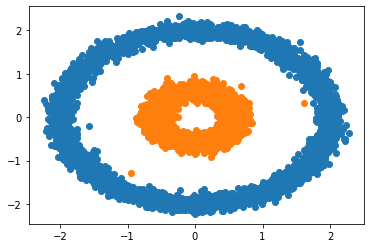

spectral clustering time is: 0:00:03.851866
spectral clustering accuracy is: 1.0
spectral clustering clusters


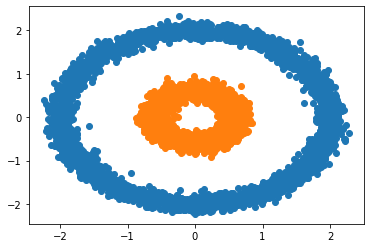

true clusters


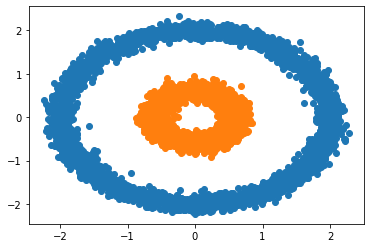

In [4]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.3, noise=.05) 

points = noisy_circles[0] * 2
true_labels = noisy_circles[1]

iters = 20
print("experiment with %d number of iterations:" % iters)
_=run_more_plots(points, true_labels, iters, 1.0, 0.01, 0.2, 2, plot=False, is_print=True, auto=False)
 
print("------------------------------------")    
print("experiment with automatic number of iterations:")  
_=run_more_plots(points, true_labels, 100, 1.0, 0.01, 0.2, 2, plot=True, is_print=True, auto=True)

experiment with 25 number of iterations:
cluster num: 0 , iterk: 24
our time is: 0:00:01.502220
our accuracy is: 1.0
spectral clustering time is: 0:00:04.527337
spectral clustering accuracy is: 1.0
------------------------------------
experiment with automatic number of iterations:
cluster num: 0 , iterk: 10
our time is: 0:00:00.822785
our accuracy is: 1.0
our method clusters


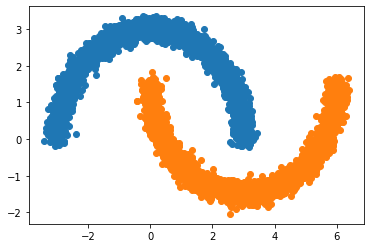

spectral clustering time is: 0:00:04.589403
spectral clustering accuracy is: 1.0
spectral clustering clusters


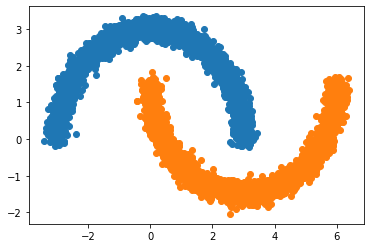

true clusters


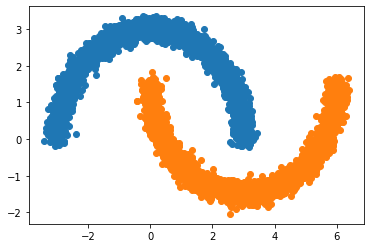

In [5]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

points = noisy_moons[0] * 3
true_labels = noisy_moons[1]

iters = 25
print("experiment with %d number of iterations:" % iters)
_=run_more_plots(points, true_labels, iters, 1.0, 0.005, 0.2, 2, plot=False, is_print=True, auto=False)

print("------------------------------------")    
print("experiment with automatic number of iterations:")  
_=run_more_plots(points, true_labels, 100, 1.0, 0.005, 0.2, 2, plot=True, is_print=True, auto=True)

experiment with 20 number of iterations:
cluster num: 0 , iterk: 19
cluster num: 1 , iterk: 19
our time is: 0:00:04.294246
our accuracy is: 1.0
spectral clustering time is: 0:00:04.604492
spectral clustering accuracy is: 1.0
------------------------------------
experiment with automatic number of iterations:
cluster num: 0 , iterk: 40
cluster num: 1 , iterk: 20
our time is: 0:00:06.645599
our accuracy is: 1.0
our method clusters


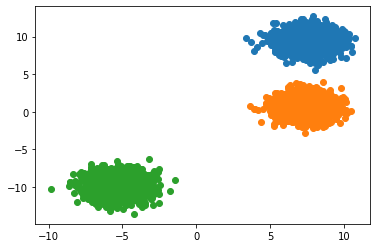

spectral clustering time is: 0:00:04.351957
spectral clustering accuracy is: 1.0
spectral clustering clusters


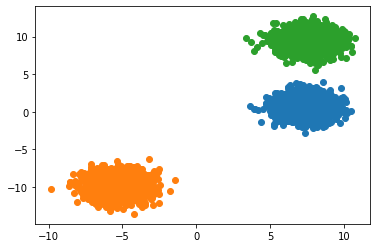

true clusters


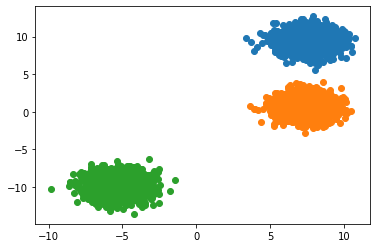

In [6]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

points = blobs[0] 
true_labels = blobs[1]

iters = 20
print("experiment with %d number of iterations:" % iters)
_=run_more_plots(points, true_labels, iters, 0.5, 0.3, 0.009, 3, plot=False, is_print=True, auto=False)
    
    
print("------------------------------------")    
print("experiment with automatic number of iterations:")
_=run_more_plots(points, true_labels, 100, 0.5, 0.3, 0.009, 3, plot=True, is_print=True, auto=True)

experiment with 60 number of iterations:
cluster num: 0 , iterk: 59
cluster num: 1 , iterk: 59
our time is: 0:00:04.071843
our accuracy is: 0.9713333333333334
spectral clustering time is: 0:00:08.263085
spectral clustering accuracy is: 0.33416666666666667
------------------------------------
experiment with automatic number of iterations:
cluster num: 0 , iterk: 75
cluster num: 1 , iterk: 45
our time is: 0:00:04.628439
our accuracy is: 0.9713333333333334
our method clusters


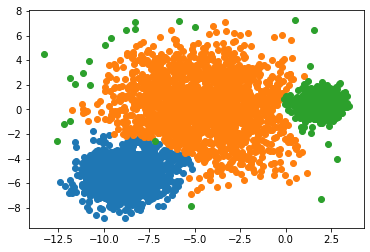

spectral clustering time is: 0:01:02.432515
spectral clustering accuracy is: 0.33416666666666667
spectral clustering clusters


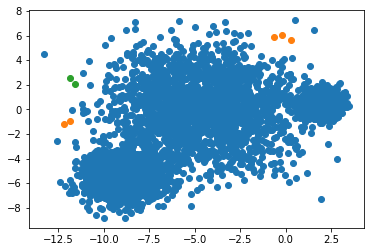

true clusters


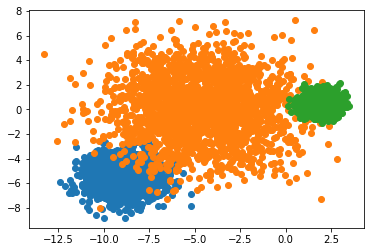

In [7]:
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

points = varied[0] 
true_labels = varied[1]

iters = 60
print("experiment with %d number of iterations:" % iters)
_=run_more_plots(points, true_labels, 60, 0.5, 0.3, 0.5, 3, plot=False, is_print=True, auto=False)

print("------------------------------------")    
print("experiment with automatic number of iterations:")
_=run_more_plots(points, true_labels, 200, 0.5, 0.3, 0.5, 3, plot=True, is_print=True, auto=True)

experiment with 50 number of iterations:
cluster num: 0 , iterk: 49
cluster num: 1 , iterk: 49
our time is: 0:00:03.016224
our accuracy is: 0.9973333333333333
spectral clustering time is: 0:00:05.633931
spectral clustering accuracy is: 0.9971666666666666
------------------------------------
experiment with automatic number of iterations:
cluster num: 0 , iterk: 35
cluster num: 1 , iterk: 35
our time is: 0:00:02.920466
our accuracy is: 0.9963333333333333
our method clusters


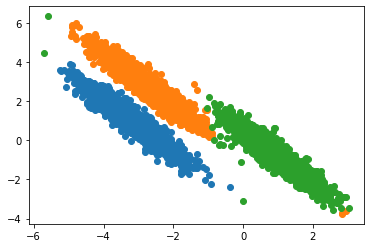

spectral clustering time is: 0:00:05.717442
spectral clustering accuracy is: 0.9971666666666666
spectral clustering clusters


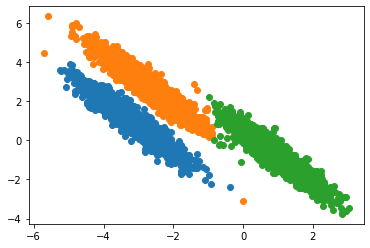

true clusters


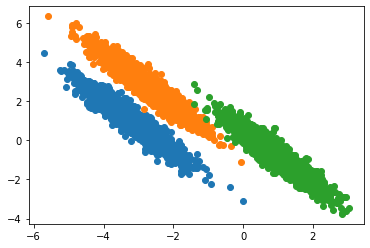

In [8]:
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

points = aniso[0] 
true_labels = aniso[1]

iters = 50
print("experiment with %d number of iterations:" % iters)
_=run_more_plots(points, true_labels, iters, 1.0, 0.3, 0.7, 3, plot=False, is_print=True, auto=False)


print("------------------------------------")    
print("experiment with automatic number of iterations:")
_=run_more_plots(points, true_labels, 200, 1.0, 0.3, 0.7, 3, plot=True, is_print=True, auto=True)